In [14]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 导入模型相关的库
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# 导入评估和交叉验证相关的库
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [19]:
# 加载数据
train_data = pd.read_csv('data/clean_train.csv')
test_data = pd.read_csv('data/clean_test.csv')

# 准备特征和标签
features = train_data.drop(['credit_score','Unnamed: 0'], axis=1)
labels = train_data['credit_score']

features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88872 entries, 0 to 88871
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   month                        88872 non-null  int64  
 1   age                          88872 non-null  float64
 2   annual_income                88872 non-null  float64
 3   monthly_inhand_salary        88872 non-null  float64
 4   num_bank_accounts            88872 non-null  float64
 5   num_credit_card              88872 non-null  float64
 6   interest_rate                88872 non-null  float64
 7   num_of_loan                  88872 non-null  float64
 8   delay_from_due_date          88872 non-null  float64
 9   num_of_delayed_payment       88872 non-null  float64
 10  changed_credit_limit         88872 non-null  float64
 11  num_credit_inquiries         88872 non-null  float64
 12  credit_mix                   88872 non-null  int64  
 13  outstanding_debt

In [15]:
train_df = pd.read_csv('./data/clean_train.csv')
X = train_df.drop(['credit_score','Unnamed: 0'], axis=1)
y = train_df['credit_score']

In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88872 entries, 0 to 88871
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   month                        88872 non-null  int64  
 1   age                          88872 non-null  float64
 2   annual_income                88872 non-null  float64
 3   monthly_inhand_salary        88872 non-null  float64
 4   num_bank_accounts            88872 non-null  float64
 5   num_credit_card              88872 non-null  float64
 6   interest_rate                88872 non-null  float64
 7   num_of_loan                  88872 non-null  float64
 8   delay_from_due_date          88872 non-null  float64
 9   num_of_delayed_payment       88872 non-null  float64
 10  changed_credit_limit         88872 non-null  float64
 11  num_credit_inquiries         88872 non-null  float64
 12  credit_mix                   88872 non-null  int64  
 13  outstanding_debt

In [44]:
# 定义评估指标
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

def evaluate_model(model, X, y, model_name):
    if model_name == 'XGBoost':
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []
        roc_auc_scores = []
        
        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            # 对于多类别，需要设置 OneVsRest 策略生成概率
            if len(np.unique(y)) > 2:
                # 多类别 ROC AUC - OneVsRest 策略
                y_proba = model.predict_proba(X_test)
                # 多类别评估指标
                accuracy_scores.append(accuracy_score(y_test, y_pred))
                precision_scores.append(precision_score(y_test, y_pred, average='macro'))
                recall_scores.append(recall_score(y_test, y_pred, average='macro'))
                f1_scores.append(f1_score(y_test, y_pred, average='macro'))
                # 对于多类别问题的 ROC AUC
                roc_auc_scores.append(roc_auc_score(y_test, y_proba, multi_class='ovr'))
            else:
                # 二分类评估
                y_proba = model.predict_proba(X_test)[:, 1]
                accuracy_scores.append(accuracy_score(y_test, y_pred))
                precision_scores.append(precision_score(y_test, y_pred))
                recall_scores.append(recall_score(y_test, y_pred))
                f1_scores.append(f1_score(y_test, y_pred))
                roc_auc_scores.append(roc_auc_score(y_test, y_proba))
        
        return {
            'Model': model_name,
            'Accuracy': np.mean(accuracy_scores),
            'Precision': np.mean(precision_scores),
            'Recall': np.mean(recall_scores),
            'F1 Score': np.mean(f1_scores),
            'ROC AUC': np.mean(roc_auc_scores)
        }
    else:
        # 为其他模型添加 ROC AUC 指标
        scoring = {
            'accuracy': 'accuracy',
            'precision_macro': 'precision_macro',
            'recall_macro': 'recall_macro',
            'f1_macro': 'f1_macro',
            'roc_auc_ovr': 'roc_auc_ovr'  # 添加多类别 ROC AUC
        }
        
        cv_results = cross_validate(model, X, y, cv=5, scoring=scoring)
        
        results = {
            'Model': model_name,
            'Accuracy': cv_results['test_accuracy'].mean(),
            'Precision': cv_results['test_precision_macro'].mean(),
            'Recall': cv_results['test_recall_macro'].mean(),
            'F1 Score': cv_results['test_f1_macro'].mean(),
            'ROC AUC': cv_results['test_roc_auc_ovr'].mean()
        }
        
        return results

In [45]:
# 初始化模型
lr_model = LogisticRegression(max_iter=100000, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)

# 评估模型
models = [
    (lr_model, 'Logistic Regression'),
    (rf_model, 'Random Forest'),
    (xgb_model, 'XGBoost')
]

results = []
for model, name in models:
    print(f"Training {name}...")
    result = evaluate_model(model, X, y, name)
    results.append(result)

# 创建结果DataFrame
results_df = pd.DataFrame(results)
results_df.set_index('Model', inplace=True)
results_df

Training Logistic Regression...
Training Random Forest...
Training XGBoost...


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
Logistic Regression,0.653322,0.633282,0.627435,0.626633,0.810635
Random Forest,0.696091,0.671246,0.673925,0.671725,0.855674
XGBoost,0.780122,0.764999,0.771133,0.767950,0.911019


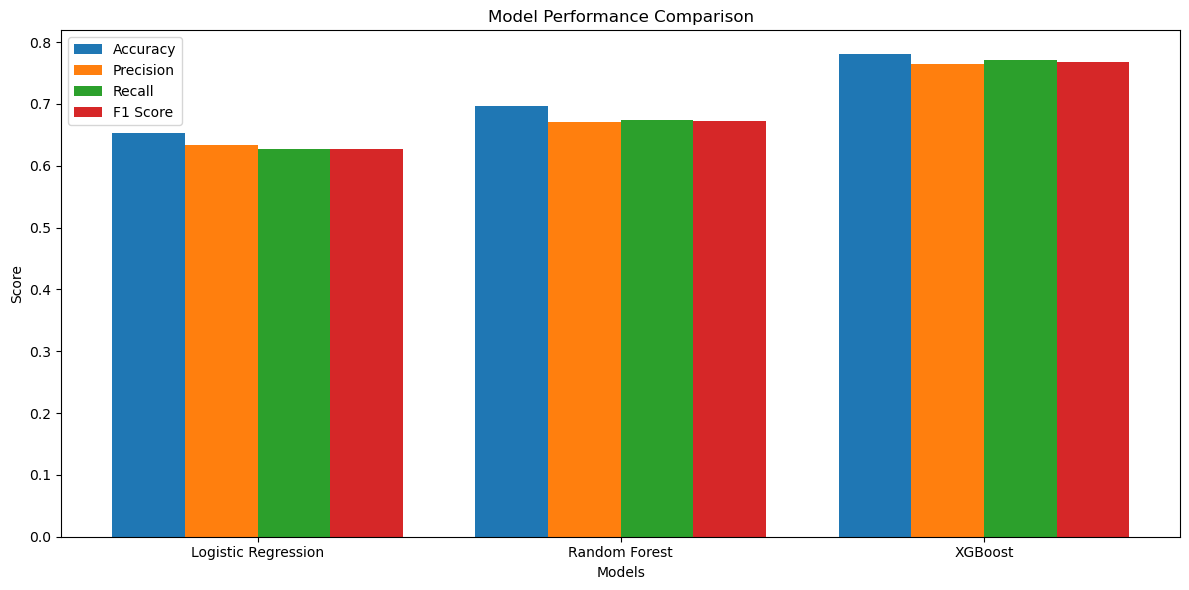

In [46]:
# 可视化模型性能比较
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

x = np.arange(len(models))
width = 0.2

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, results_df[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width*1.5, results_df.index)
plt.legend()
plt.tight_layout()
plt.savefig('./image/model_performance_comparison.png')
plt.show()